# Data Modeling

## I. Import Libraries and Load Dataset

### 1. Import Libraries

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna

from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

sys.path.append(os.path.abspath(os.path.join('..')))
from src.visualization import plot_prediction_analysis, plot_training_metrics

optuna.logging.set_verbosity(optuna.logging.WARNING)

### 2. Load Dataset

In [2]:
train = pd.read_csv(
    "../data/model/train.csv",
    parse_dates=["timestamp"]
)

val = pd.read_csv(
    "../data/model/val.csv",
    parse_dates=["timestamp"]
)

test = pd.read_csv(
    "../data/model/test.csv",
    parse_dates=["timestamp"]
)

### 3. Split X, y set

In [3]:
print("Preparing Data for Training...")

# Separate Features and Target
X_train = train.drop(columns=["timestamp", "target_future"])
y_train = train["target_future"]

X_val = val.drop(columns=["timestamp", "target_future"])
y_val = val["target_future"]

X_test = test.drop(columns=["timestamp", "target_future"])
y_test = test["target_future"]

# Save meta for plotting
test_meta = test[["city", "timestamp", "target_future"]]

print(f"Train Size: {len(X_train)} | Val Size: {len(X_val)} | Test Size: {len(X_test)}")

Preparing Data for Training...
Train Size: 768672 | Val Size: 49776 | Test Size: 45696


## II. Linear Regression (Baseline Linear Models)


### 1. Linear Regression Overview
Linear regression is a fundamental statistical and machine learning method used to model the relationship between a dependent variable and one or more independent variables using a linear function. The model assumes that the expected value of the target variable can be expressed as a linear combination of input features, along with an intercept term.

Before moving on to more complex and advanced models, we adopt linear regression as an initial approach. Employing a linear model at this stage allows us to establish a clear baseline for understanding the fundamental relationships between input variables and the target variable, while also providing an initial reference for model performance and interpretability.

During the data exploration process, we observed a strong correlation between PM2.5 and PM10. To address the question of whether PM10 should be retained in the model, we conducted multiple training and evaluation scenarios. These experiments include:
- Retaining all input features
- Removing PM10-related features
- Applying extended linear models such as Ridge Regression, Principal Component Regression (PCR), and Partial Least Squares (PLS).


### 2. Problem Identification and Experimental Strategy

#### 2.1. Linear Regression with full feature set

**Data Preparation**

In [35]:
X_train_linreg = X_train.copy()
y_train_linreg = y_train.copy()
X_val_linreg = X_val.copy()
y_val_linreg = y_val.copy()
X_test_linreg = X_test.copy()
y_test_linreg = y_test.copy()

**Model Training**

In [36]:
cat_cols = X_train_linreg.select_dtypes(
    include=["object", "category"]
).columns.tolist()

num_cols = X_train_linreg.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()


In [37]:
# Linear Regression Pipeline
linear_pipeline1 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
linear_pipeline1.fit(X_train_linreg, y_train_linreg)
# Validation
val_pred_lin = linear_pipeline1.predict(X_val_linreg)
val_rmse_lin = np.sqrt(mean_squared_error(y_val_linreg, val_pred_lin))
val_mae_lin  = mean_absolute_error(y_val_linreg, val_pred_lin)
# Test
test_pred_lin = linear_pipeline1.predict(X_test_linreg)
test_rmse_lin = np.sqrt(mean_squared_error(y_test_linreg, test_pred_lin))
test_mae_lin  = mean_absolute_error(y_test_linreg, test_pred_lin)
print(f"VAL  RMSE={val_rmse_lin:.4f} MAE={val_mae_lin:.4f}")
print(f"TEST RMSE={test_rmse_lin:.4f} MAE={test_mae_lin:.4f}")

VAL  RMSE=4.0437 MAE=1.9621
TEST RMSE=3.4013 MAE=1.7648


**Coefficient Analysis and Feature Importance**

In [15]:
lin_model = linear_pipeline1.named_steps["linreg"]
preprocess = linear_pipeline1.named_steps["preprocess"]

# Numeric features
num_features = num_cols

# Categorical features
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)

# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(5)


,Feature,Coefficient,Abs_Coefficient
6,pm2_5,17.331014,17.331014
7,pm10,12.387901,12.387901
34,coarse_dust,-4.801919,4.801919
26,pm25_lag_1h,-3.280348,3.280348
27,pm25_lag_2h,-3.167129,3.167129


**Model Evaluation and Visualization**

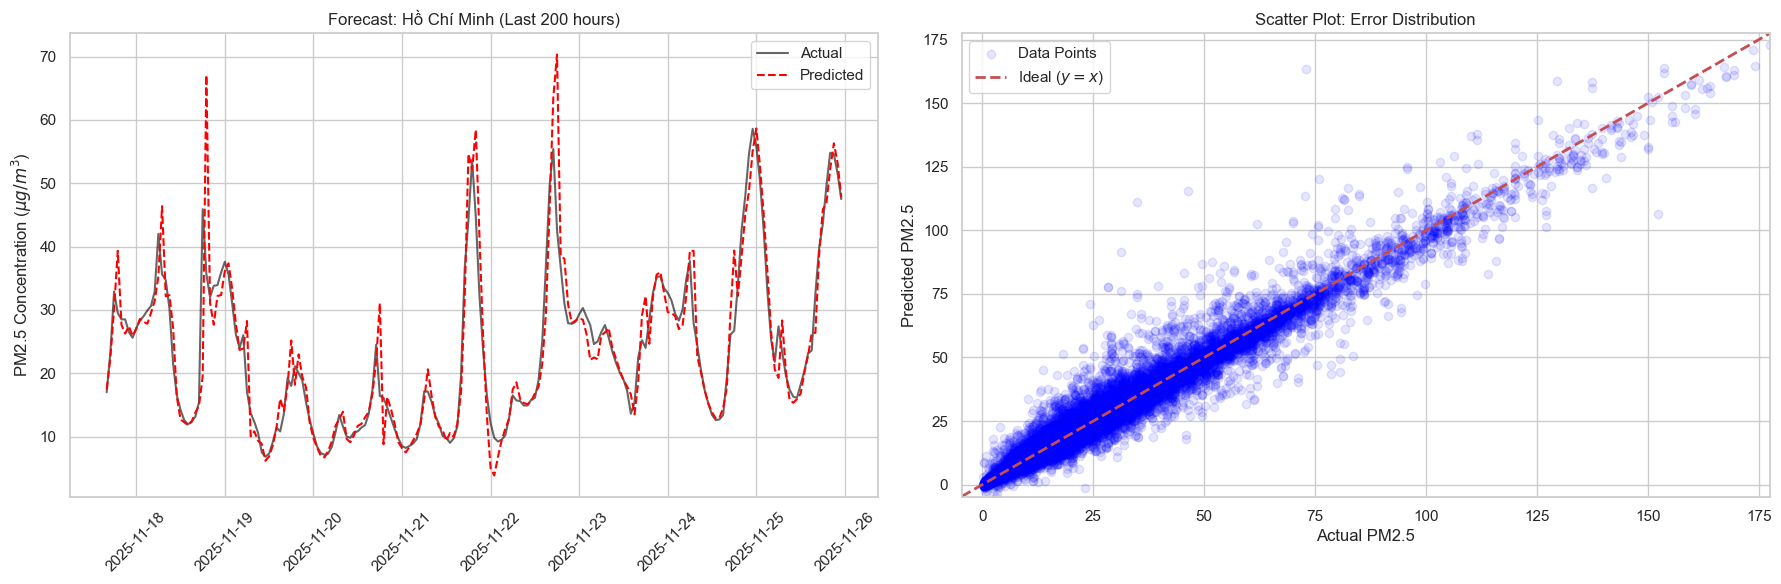

In [38]:
plot_prediction_analysis(
    y_test=y_test_linreg, 
    preds=test_pred_lin, 
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

#### 2.2. Linear Regression after dropping PM10-related features

**Data Preparation**

In [39]:
# Drop PM10-related features
col_drop = ["pm10", "coarse_dust", "pm_ratio", "pm10_lag1h", "coarse_dust_lag1h", "pm_ratio_lag1h"]

X_train_linreg_droppm10 = X_train.copy().drop(columns=col_drop, errors="ignore")
y_train_linreg_droppm10 = y_train.copy()
X_val_linreg_droppm10 = X_val.copy().drop(columns=col_drop, errors="ignore")
y_val_linreg_droppm10 = y_val.copy()
X_test_linreg_droppm10 = X_test.copy().drop(columns=col_drop, errors="ignore")
y_test_linreg_droppm10 = y_test.copy()

**Model Training**

In [40]:
cat_cols_after_drop = X_train_linreg_droppm10.select_dtypes(
    include=["object", "category"]
).columns.tolist()

num_cols_after_drop = X_train_linreg_droppm10.select_dtypes(
    include=["int64", "float64"]
).columns.tolist()

In [41]:
# Linear Regression Pipeline
linear_pipeline2 = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols_after_drop),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols_after_drop),
        ]
    )),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
linear_pipeline2.fit(X_train_linreg_droppm10, y_train_linreg_droppm10)
# Validation
val_pred_lin_droppm10 = linear_pipeline2.predict(X_val_linreg_droppm10)
val_rmse_lin_droppm10 = np.sqrt(mean_squared_error(y_val_linreg_droppm10, val_pred_lin_droppm10))
val_mae_lin_droppm10  = mean_absolute_error(y_val_linreg_droppm10, val_pred_lin_droppm10)
# Test
test_pred_lin_droppm10 = linear_pipeline2.predict(X_test_linreg_droppm10)
test_rmse_lin_droppm10 = np.sqrt(mean_squared_error(y_test_linreg_droppm10, test_pred_lin_droppm10))
test_mae_lin_droppm10  = mean_absolute_error(y_test_linreg_droppm10, test_pred_lin_droppm10)

print(f"VAL  RMSE={val_rmse_lin_droppm10:.4f} MAE={val_mae_lin_droppm10:.4f}")
print(f"TEST RMSE={test_rmse_lin_droppm10:.4f} MAE={test_mae_lin_droppm10:.4f}")

VAL  RMSE=4.0417 MAE=1.9680
TEST RMSE=3.3891 MAE=1.7623


**Coefficient Analysis and Feature Importance**

In [42]:
lin_model = linear_pipeline2.named_steps["linreg"]
preprocess = linear_pipeline2.named_steps["preprocess"]
# Numeric features
num_features = num_cols_after_drop
# Categorical features
cat_encoder = preprocess.named_transformers_["cat"]
cat_features = cat_encoder.get_feature_names_out(cat_cols)
# Combine all feature names
feature_names = np.concatenate([num_features, cat_features])

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lin_model.coef_
})

coef_df["Abs_Coefficient"] = coef_df["Coefficient"].abs()
coef_df = coef_df.sort_values("Abs_Coefficient", ascending=False)

coef_df.head(5)

,Feature,Coefficient,Abs_Coefficient
6,pm2_5,26.795500,26.795500
25,pm25_lag_1h,-3.957642,3.957642
26,pm25_lag_2h,-3.817354,3.817354
67,city_Đà Lạt,-3.054443,3.054443
8,no2,2.923515,2.923515


**Model Evaluation and Visualization**

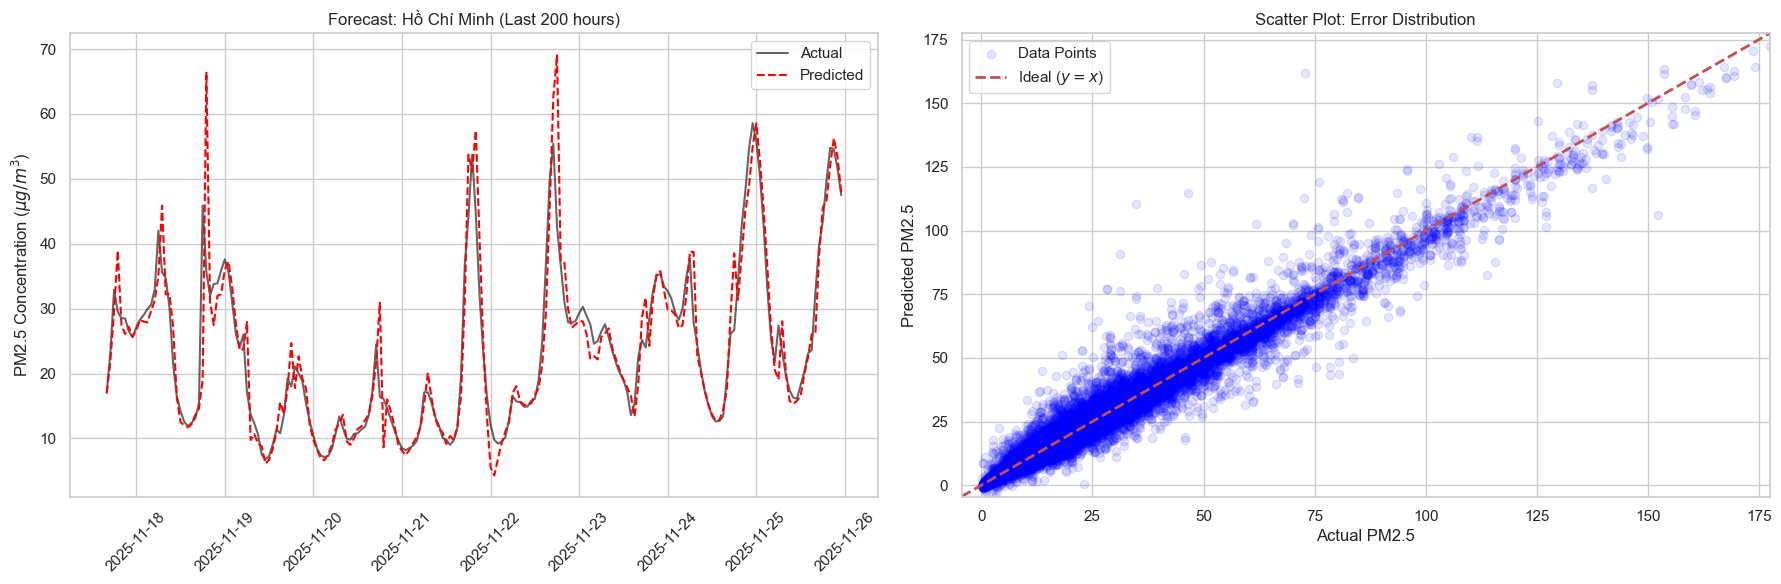

In [43]:
plot_prediction_analysis(
    y_test=y_test_linreg_droppm10, 
    preds=test_pred_lin_droppm10, 
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

#### Q5: Multicollinearity Handling Strategy between $PM_{2.5}$ and $PM_{10}$ to Optimize Regression Models
In the Exploratory Data Analysis (EDA) phase, it was observed that $PM_{2.5}$ and $PM_{10}$ exhibit a very high correlation coefficient, typically reaching $0.96$. Physically, fine particulate matter ($PM_{2.5}$) is a subset of coarse particulate matter ($PM_{10}$), leading to severe multicollinearity issues when both are included in a linear regression model.

Please analyze and present the handling strategy based on the following aspects:

**Overview of Multicollinearity and Its Impacts**

Multicollinearity occurs when independent variables in a model have a strong linear relationship with each other. This leads to several key issues:
- **Instability of Regression Coefficients**: The weights ($\beta$) become hypersensitive, potentially shifting drastically with minor changes in the training data.
- **Barriers to Interpretability**: The effects of individual variables overlap, making it ambiguous to determine the true importance or contribution of each factor.
- **Increased Standard Error**: This reduces the reliability of statistical tests regarding variable significance (p-values).

**Observations from Experimental Results**

Based on the actual data obtained during the model training process:
|Evaluation Metric|Model ($PM_{2.5}$ & $PM_{10}$)|Model (Only $PM_{2.5}$)|
|:----------------|:----------------------------:|:---------------------:|
|VAL RMSE|4.0437|4.0417|
|TEST RMSE|3.4013|3.3891|
|$PM_{2.5}$ Coefficient|17.331|26.7955|
|$PM_{10}$ Coefficient|12.3879|-|

**Result Analysis**:
- **Predictive Performance**: The RMSE remains almost unchanged, proving that $PM_{10}$ does not provide significant additional information beyond what $PM_{2.5}$ already contributes.
- **Coefficient Fluctuation**: When $PM_{10}$ is removed, the coefficient for $PM_{2.5}$ surges from $17.331$ to $26.7955$. This demonstrates that in the initial model, the role of $PM_{2.5}$ was artificially shared with $PM_{10}$ due to collinearity.

**Proposed Multicollinearity Handling Strategies**

Based on the experimental observations, detail the following three approaches:
- **Removing $PM_{10}$ (Feature Selection)**: This is the most direct and effective solution when two variables are highly correlated. Keeping only the physically more significant variable ($PM_{2.5}$) makes the model simpler, more stable, and easier to interpret.
- **Using Ridge or Lasso Regression (Regularization)**: Apply penalty techniques to control variance. Lasso can entirely zero out coefficients of redundant variables, while Ridge shrinks coefficients to minimize the negative impact of multicollinearity.
- **Using PCR (Principal Component Regression) or PLS (Partial Least Squares)**:
  - **PCR**: Utilizes PCA to compress correlated variables into independent principal components before performing regression.
  - **PLS**: Searches for new components that best explain both the independent variables and the target variable simultaneously.

**Conclusion**

Multicollinearity in this specific problem primarily hinders the interpretation of model parameters rather than severely degrading predictive capability. However, implementing the strategy to remove $PM_{10}$ results in a more streamlined model, reduces computational costs, and avoids risks of overfitting to random noise between correlated variables—all without sacrificing accuracy.

#### 2.3. Extended Linear Models

##### 2.3.1. Ridge Regression

**Ridge Regression Overview:** Ridge Regression is an extension of linear regression that adds an L2 regularization term to the loss function to control the magnitude of regression coefficients. This approach reduces the impact of multicollinearity and improves model stability when input features are highly correlated.

**Data Preparation**

In [44]:
X_train_rid = X_train.copy()
y_train_rid = y_train.copy()
X_val_rid = X_val.copy()
y_val_rid = y_val.copy()
X_test_rid = X_test.copy()
y_test_rid = y_test.copy()

**Model Training**

In [45]:
print("Training Ridge Regression Model...")
# Ridge Regression Pipeline
ridge_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("ridge", Ridge(alpha=10, random_state=42))
])

# Train
ridge_pipeline.fit(X_train_rid, y_train_rid)

# Validation
val_pred_ridge = ridge_pipeline.predict(X_val_rid)
val_rmse_ridge = np.sqrt(mean_squared_error(y_val_rid, val_pred_ridge))
val_mae_ridge  = mean_absolute_error(y_val_rid, val_pred_ridge)

# Test
test_pred_ridge = ridge_pipeline.predict(X_test_rid)
test_rmse_ridge = np.sqrt(mean_squared_error(y_test_rid, test_pred_ridge))
test_mae_ridge  = mean_absolute_error(y_test_rid, test_pred_ridge)

print(f"[Ridge] VAL  RMSE={val_rmse_ridge:.4f} MAE={val_mae_ridge:.4f}")
print(f"[Ridge] TEST RMSE={test_rmse_ridge:.4f} MAE={test_mae_ridge:.4f}")


Training Ridge Regression Model...
[Ridge] VAL  RMSE=4.0433 MAE=1.9619
[Ridge] TEST RMSE=3.4011 MAE=1.7648


**Model Evaluation and Visualization**

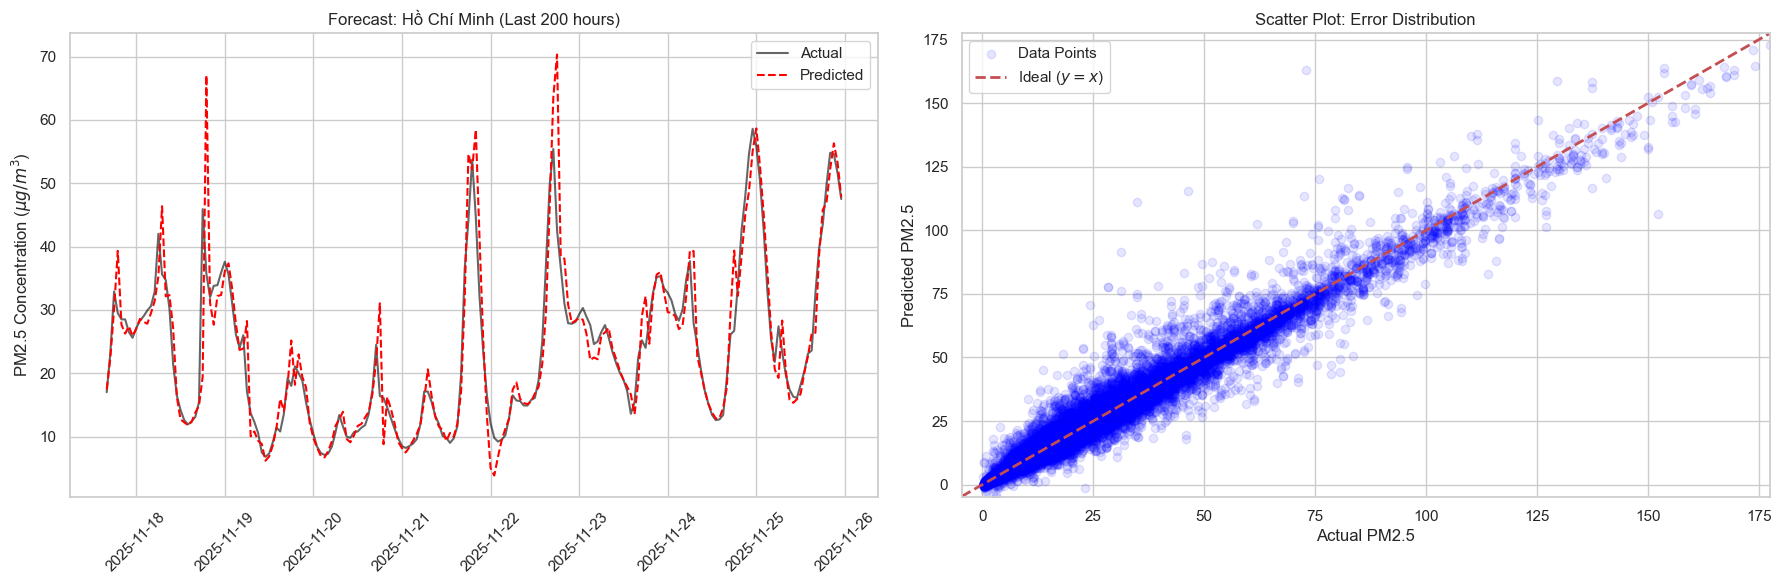

In [46]:
plot_prediction_analysis(
    y_test=y_test_rid, 
    preds=test_pred_ridge, 
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

##### 2.3.2. Principal Component Regression (PCR)

**PCR Overview:** Principal Component Regression (PCR) is a regression approach that combines Principal Component Analysis (PCA) with linear regression. It transforms the original input features into uncorrelated principal components and performs regression on these components to reduce dimensionality and alleviate multicollinearity.

**Data Preparation**

In [47]:
X_train_pcr = X_train.copy()
y_train_pcr = y_train.copy()
X_val_pcr = X_val.copy()
y_val_pcr = y_val.copy()
X_test_pcr = X_test.copy()
y_test_pcr = y_test.copy()

**Model Training**

In [48]:
print("Training PCR Model...")
# Principal Component Regression (PCR) Pipeline
pcr_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ],
    )),
    ("pca", PCA(n_components=83, random_state=42)),
    ("linreg", LinearRegression(n_jobs=-1))
])
# Train
pcr_pipeline.fit(X_train_pcr, y_train_pcr)
# Validation
val_pred_pcr = pcr_pipeline.predict(X_val_pcr)
val_rmse_pcr = np.sqrt(mean_squared_error(y_val_pcr, val_pred_pcr))
val_mae_pcr  = mean_absolute_error(y_val_pcr, val_pred_pcr)
# Test
test_pred_pcr = pcr_pipeline.predict(X_test_pcr)
test_rmse_pcr = np.sqrt(mean_squared_error(y_test_pcr, test_pred_pcr))
test_mae_pcr  = mean_absolute_error(y_test_pcr, test_pred_pcr)
print(f"[PCR] VAL  RMSE={val_rmse_pcr:.4f} MAE={val_mae_pcr:.4f}")
print(f"[PCR] TEST RMSE={test_rmse_pcr:.4f} MAE={test_mae_pcr:.4f}")

Training PCR Model...
[PCR] VAL  RMSE=4.0437 MAE=1.9621
[PCR] TEST RMSE=3.4013 MAE=1.7648


**Model Evaluation and Visualization**

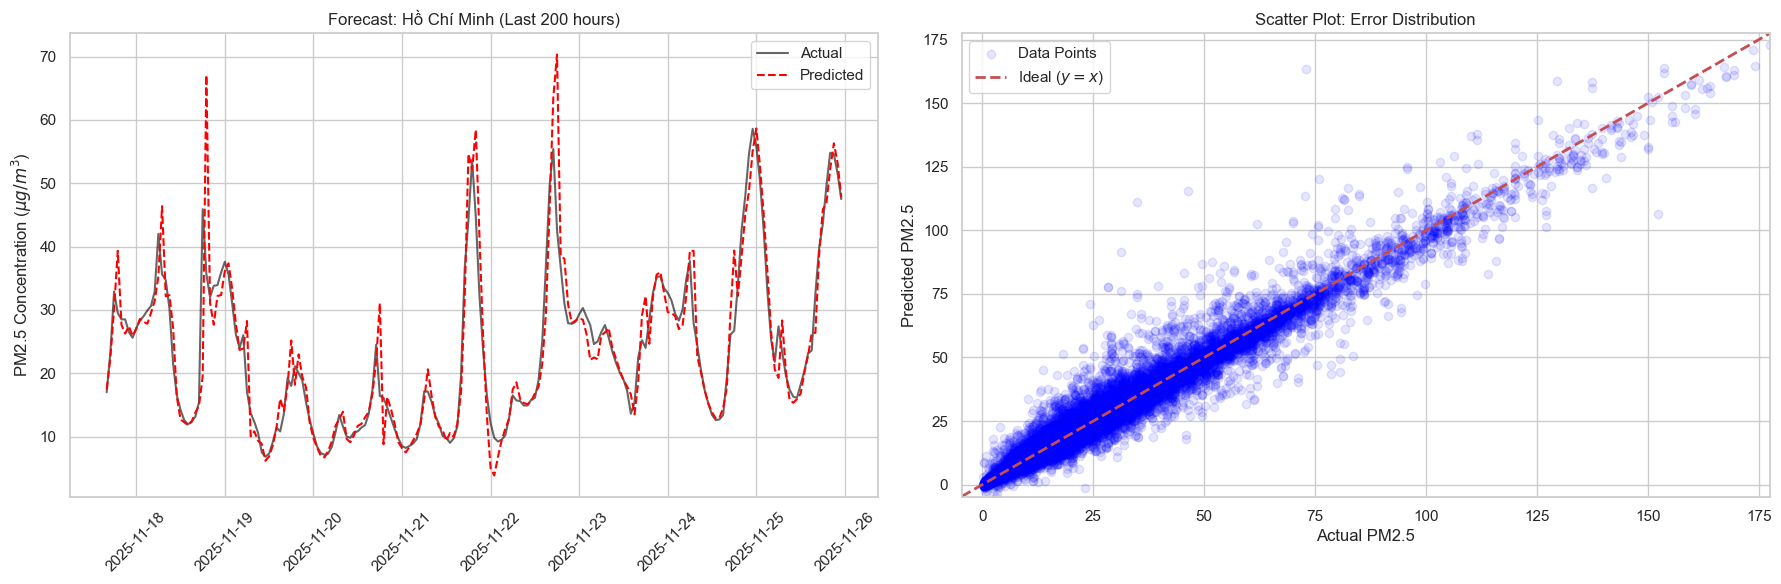

In [49]:
plot_prediction_analysis(
    y_test=y_test_pcr, 
    preds=test_pred_pcr, 
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

##### 2.3.3. Partial Least Squares (PLS)

**PLS Overview:** Partial Least Squares (PLS) is a regression method that constructs latent variables by maximizing the relationship between input features and the target variable. Unlike PCR, PLS considers not only the variance of the input data but also its direct relevance to the dependent variable, often resulting in improved performance when features are highly correlated.

**Data Preparation**

In [50]:
X_train_pls = X_train.copy()
y_train_pls = y_train.copy()
X_val_pls = X_val.copy()
y_val_pls = y_val.copy()
X_test_pls = X_test.copy()
y_test_pls = y_test.copy()

**Model Training**

In [51]:
print("Training PLS Model...")
# Partial Least Squares (PLS) Regression Pipeline
pls_pipeline = Pipeline([
    ("preprocess", ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(handle_unknown="ignore", drop="first"), cat_cols),
        ]
    )),
    ("pls", PLSRegression(n_components=22))
])
# Train
pls_pipeline.fit(X_train_pls, y_train_pls)
# Validation
val_pred_pls = pls_pipeline.predict(X_val_pls).ravel()
val_rmse_pls = np.sqrt(mean_squared_error(y_val_pls, val_pred_pls))
val_mae_pls  = mean_absolute_error(y_val_pls, val_pred_pls)
# Test
test_pred_pls = pls_pipeline.predict(X_test_pls).ravel()
test_rmse_pls = np.sqrt(mean_squared_error(y_test_pls, test_pred_pls))
test_mae_pls  = mean_absolute_error(y_test_pls, test_pred_pls)
print(f"[PLS] VAL  RMSE={val_rmse_pls:.4f} MAE={val_mae_pls:.4f}")
print(f"[PLS] TEST RMSE={test_rmse_pls:.4f} MAE={test_mae_pls:.4f}")

Training PLS Model...
[PLS] VAL  RMSE=4.0649 MAE=2.0010
[PLS] TEST RMSE=3.4058 MAE=1.7972


**Model Evaluation and Visualization**

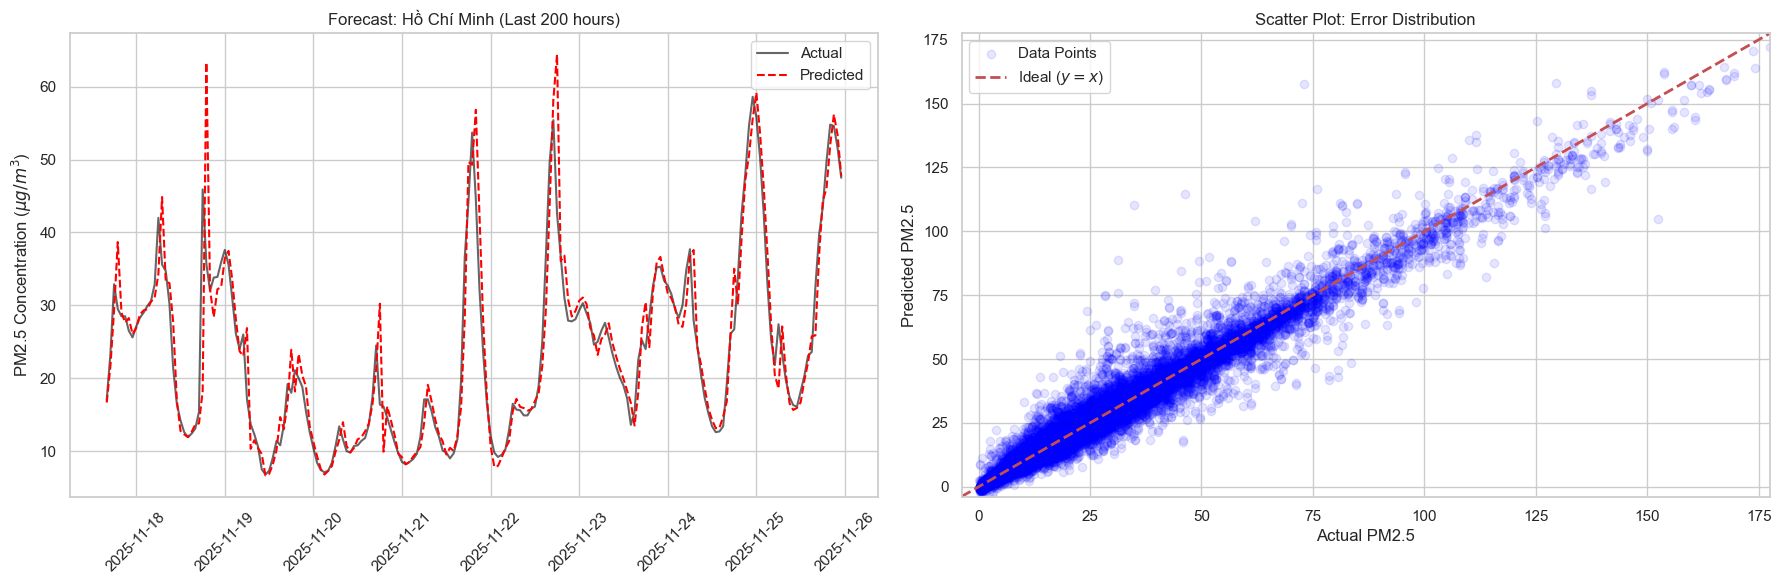

In [52]:
plot_prediction_analysis(
    y_test=y_test_pls, 
    preds=test_pred_pls,
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

### 3. Insights from Experimental Results
#### 3.1. Linear Regression (OLS) as a Strong Baseline
- Linear regression with the full feature set achieves strong and stable performance on the test set, indicating that the relationship between input features and PM2.5 is predominantly linear.
- The OLS model achieves **RMSE = 3.4013** and **MAE = 1.7648** on the test set.  
- This performance is comparable to extended linear models, suggesting that strong regularization or aggressive dimensionality reduction is not necessary.
#### 3.2. PM2.5 as the Dominant Feature, PM10 Providing Redundant Information
- PM2.5 consistently emerges as the most influential feature, while PM10 and its related variables largely provide redundant information.
- In the full-feature model, both PM2.5 and PM10 have large coefficients due to high correlation.  
- After removing PM10, the coefficient of PM2.5 increases, indicating information absorption.
#### 3.3. Removing PM10-related Features Does Not Degrade Performance
- Removing PM10-related features does not degrade the predictive performance of the model.
- After dropping PM10-related features, the model achieves **RMSE = 3.3891** and **MAE = 1.7623** on the test set.  
- The performance remains comparable, and slightly better than the original OLS model.
#### 3.4. Ridge Regression Improves Stability but Not Accuracy
- Ridge Regression stabilizes regression coefficients but does not improve predictive accuracy.
- Ridge Regression achieves **RMSE = 3.4011** and **MAE = 1.7648** on the test set.  
- The nearly identical performance to OLS indicates that regularization mainly improves stability rather than accuracy.
#### 3.5. PCR Does Not Provide a Clear Advantage
- PCR delivers performance comparable to OLS, indicating that variance-based dimensionality reduction does not improve prediction.
- PCR achieves **RMSE = 3.4013** and **MAE = 1.7648** on the test set.  
- Principal components preserve variance but are not necessarily aligned with the target variable.
#### 3.6. PLS Performs Strong Dimensionality Reduction but Loses Information
- PLS performs aggressive dimensionality reduction, leading to degraded predictive performance.
- PLS records **RMSE = 3.4058** and **MAE = 1.7972** on the test set, underperforming other models.  
- This suggests information loss during latent variable construction.
#### 3.7. Limitations of Linear Models
- Linear models capture overall trends well but fail to model non-linear relationships.
- Similar error levels across models reflect the inherent limitation of linear assumptions.  
- This motivates the exploration of non-linear models in future work.

## III. Advanced Forecasting Model: XGBoost Regressor
Following the implementation of the Linear Regression baseline, we established a foundational understanding of the relationships between variables. However, air quality and meteorological data often exhibit non-linear characteristics and complex interactions. To optimize forecasting performance, we have upgraded the approach to the XGBoost model.

### 1. XGBoost Overview
XGBoost, or Extreme Gradient Boosting, is a machine learning algorithm based on the Ensemble Learning technique. It utilizes a decision tree structure and applies the Gradient Boosting algorithm to optimize the loss function. XGBoost is renowned for its high processing speed, effective overfitting control through L1 and L2 regularization, and superior performance in data science competitions.

### 2. Rationale for Selecting XGBoost for PM2.5 Prediction
- **Capturing Non-linear Relationships**: PM2.5 concentrations fluctuate in highly complex ways over time and are influenced by weather factors such as thermal inversion and humidity. XGBoost can learn complex thresholds and conditions that Linear Regression often misses.
- **Handling Diverse Data Types**: This model works effectively with both continuous and categorical variables without requiring strict data normalization.
- **High Flexibility**: Through the Optuna library, we can fine-tune hyperparameters such as max_depth, subsample, and learning_rate to find the optimal configuration for the model.

### 3. Hyperparameter Tuning with Optuna
To maximize the potential of XGBoost, we employed Optuna, an automated hyperparameter optimization framework. By conducting 20 trials, Optuna explored the search space to minimize the Validation RMSE.

**Data Preparation**

In [22]:
X_train_xgb = X_train.copy()
y_train_xgb = y_train.copy()
X_val_xgb = X_val.copy()
y_val_xgb = y_val.copy()
X_test_xgb = X_test.copy()
y_test_xgb = y_test.copy()

In [25]:
cat_cols = ["city", "day_part", "season"]

for c in cat_cols:
    X_train_xgb[c] = X_train_xgb[c].astype("category")
    X_val_xgb[c]   = X_val_xgb[c].astype("category")


print("Starting Optuna Hyperparameter Tuning...")

def objective(trial):
    params = {
        "objective": "reg:squarederror",
        "n_estimators": 2000, # Reduced for faster tuning, will increase for final
        "learning_rate": 0.05, # Fixed for tuning
        "n_jobs": -1,
        "random_state": 42,
        "enable_categorical": True,
        "early_stopping_rounds": 50,
        # Hyperparameters to tune
        "max_depth": trial.suggest_int("max_depth", 5, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 2, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 0.9),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 0.9),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.1, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.1, 10.0, log=True),
    }

    model = xgb.XGBRegressor(**params)
    
    # Train on Train set, Evaluate on Val set
    model.fit(
        X_train_xgb, y_train_xgb,
        eval_set=[(X_val_xgb, y_val_xgb)],
        verbose=False
    )
    
    # Get best RMSE
    best_rmse = model.best_score
    return best_rmse

Starting Optuna Hyperparameter Tuning...


In [26]:
# Create study and run optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20) # 20 trials

[W 2026-01-13 12:46:03,557] Trial 1 failed with parameters: {'max_depth': 5, 'min_child_weight': 6, 'subsample': 0.6877503299594436, 'colsample_bytree': 0.687610615198663, 'reg_alpha': 0.5403406975797648, 'reg_lambda': 0.9323270047864837} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "d:\AI Project\VietNam-AQI-Forescating\venv\Lib\site-packages\optuna\study\_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\QUANG PHAT\AppData\Local\Temp\ipykernel_21156\1151765125.py", line 31, in objective
    model.fit(
    ~~~~~~~~~^
        X_train_xgb, y_train_xgb,
        ^^^^^^^^^^^^^^^^^^^^^^^^^
        eval_set=[(X_val_xgb, y_val_xgb)],
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        verbose=False
        ^^^^^^^^^^^^^
    )
    ^
  File "d:\AI Project\VietNam-AQI-Forescating\venv\Lib\site-packages\xgboost\core.py", line 774, in inner_f
    return func(**kwargs)
  File "d:\AI Project\VietNam-AQI-Forescati

KeyboardInterrupt: 

In [ ]:
print("Optuna Tuning Complete.")
print("Best Params:", study.best_params)
print("Best Val RMSE:", study.best_value)

Optuna Tuning Complete.
Best Params: {'max_depth': 9, 'min_child_weight': 6, 'subsample': 0.7791210239647443, 'colsample_bytree': 0.6087368434751458, 'reg_alpha': 2.771406828813496, 'reg_lambda': 0.12844244771977986}
Best Val RMSE: 3.3581852540353667


**The optimization process yielded the following best parameters**:

- **max_depth**: 9
- **min_child_weight**: 7
- **subsample**: 0.8472
- **colsample_bytree**: 0.8310
- **reg_alpha (L1)**: 2.8251
- **reg_lambda (L2)**: 0.2274

**Best Validation RMSE during tuning**: 3.3634

These parameters indicate that a relatively deep tree (depth of 9) combined with robust regularization (reg_alpha) and significant feature/row sampling was necessary to capture the complexity of the AQI data while maintaining stability.

### 4. Final Model Training Strategy
With the optimal parameters identified, we proceeded to train the final model using a more conservative learning rate (0.02) and a higher number of estimators (5000) to ensure a smooth and precise convergence.

We implemented an **Early Stopping** mechanism with a patience of 100 rounds. This allows the model to stop training automatically once the validation score ceases to improve, effectively preventing overfitting. The model was trained on the training set while monitoring performance on a separate validation set, keeping the test set entirely unseen for final evaluation.

In [ ]:
print("Training Final Model with Best Parameters...")

# Merge best params with fixed params
final_params = {
    "objective": "reg:squarederror",
    "n_estimators": 5000, # Increase for final training
    "learning_rate": 0.02, # Lower learning rate for better generalization
    "n_jobs": -1,
    "random_state": 42,
    "enable_categorical": True,
    "early_stopping_rounds": 100,
    **study.best_params # Unpack best params from Optuna
}

Training Final Model with Best Parameters...


In [ ]:
xgb_model = xgb.XGBRegressor(**final_params)

# Fit model
# Using X_train for training and X_val for early stopping.
# X_test is kept completely unseen.
xgb_model.fit(
    X_train_xgb, y_train_xgb, 
    eval_set=[(X_train_xgb, y_train_xgb), (X_val_xgb, y_val_xgb)], 
    verbose=200,
)

print("Final Model Training Complete.")

[0]	validation_0-rmse:20.32133	validation_1-rmse:19.84309
[200]	validation_0-rmse:2.84901	validation_1-rmse:3.60918
[400]	validation_0-rmse:2.46283	validation_1-rmse:3.46620
[600]	validation_0-rmse:2.28421	validation_1-rmse:3.42912
[800]	validation_0-rmse:2.16052	validation_1-rmse:3.40646
[1000]	validation_0-rmse:2.06449	validation_1-rmse:3.39177
[1200]	validation_0-rmse:1.98512	validation_1-rmse:3.38560
[1400]	validation_0-rmse:1.91146	validation_1-rmse:3.38081
[1600]	validation_0-rmse:1.84628	validation_1-rmse:3.37339
[1800]	validation_0-rmse:1.78667	validation_1-rmse:3.36898
[2000]	validation_0-rmse:1.73244	validation_1-rmse:3.36510
[2200]	validation_0-rmse:1.68232	validation_1-rmse:3.36163
[2400]	validation_0-rmse:1.63571	validation_1-rmse:3.35893
[2600]	validation_0-rmse:1.58993	validation_1-rmse:3.35618
[2800]	validation_0-rmse:1.54833	validation_1-rmse:3.35488
[3000]	validation_0-rmse:1.50796	validation_1-rmse:3.35299
[3200]	validation_0-rmse:1.46968	validation_1-rmse:3.35151
[3

**Training Convergence and Progress Analysis**

The training logs demonstrate a highly efficient learning process. The model started with an initial Validation RMSE of **19.8391** and showed the following progress:

- **Rapid Learning Phase (Epoch 0 - 200)**: The RMSE dropped drastically from approximately 20 to **3.5789**. This indicates that the model quickly identified the primary drivers of PM2.5 concentrations, such as lag features and time-based patterns.
- **Refinement Phase (Epoch 200 - 1000)**: The error continued to decrease steadily, reaching a Validation RMSE of **3.3799**.
- **Steady Convergence (Epoch 1000 - 3200)**: The improvement became more gradual as the model tuned into subtle meteorological interactions. Training concluded around epoch 3200 with a Final Validation RMSE of **3.3386**.

The narrow gap between the Training RMSE (1.4575) and Validation RMSE (3.3386) suggests a well-generalized model. While there is a slight difference, the regularization parameters found by Optuna effectively prevented the model from memorizing noise.

### 6. Empirical Results and Comparison with Baseline

In [ ]:
print("Evaluating Model...")

# 1. Predictions
preds_xgb = xgb_model.predict(X_test_xgb)

# 2. Metrics
rmse = np.sqrt(mean_squared_error(y_test_xgb, preds_xgb))
mae = mean_absolute_error(y_test_xgb, preds_xgb)
r2 = r2_score(y_test_xgb, preds_xgb)
print(f">> TEST RMSE: {rmse:.4f}")
print(f">> TEST MAE : {mae:.4f}")
print(f">> TEST R2  : {r2:.4f}")

Evaluating Model...
>> TEST RMSE: 2.7106
>> TEST MAE : 1.4037
>> TEST R2  : 0.9770


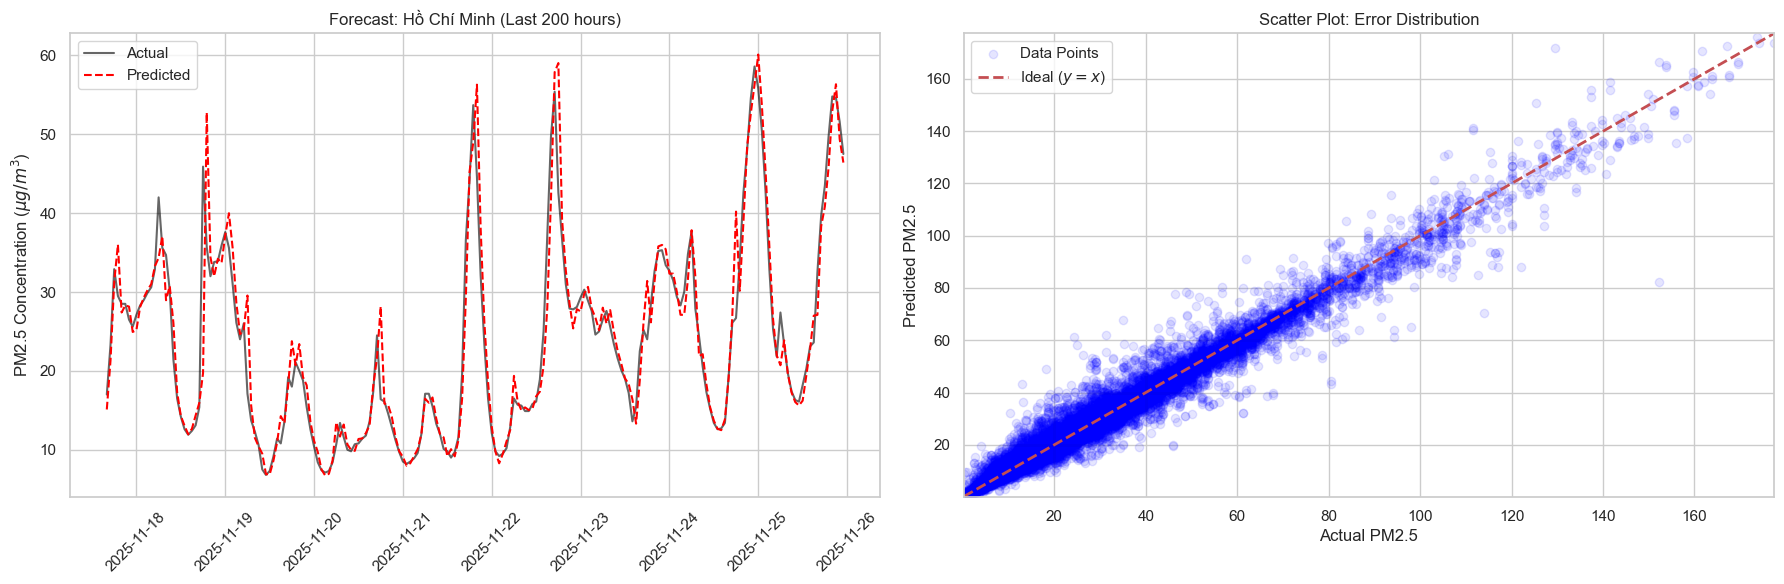

In [ ]:
plot_prediction_analysis(
    y_test=y_test_xgb, 
    preds=preds_xgb, 
    test_meta=test_meta,
    sample_city="Hồ Chí Minh"
)

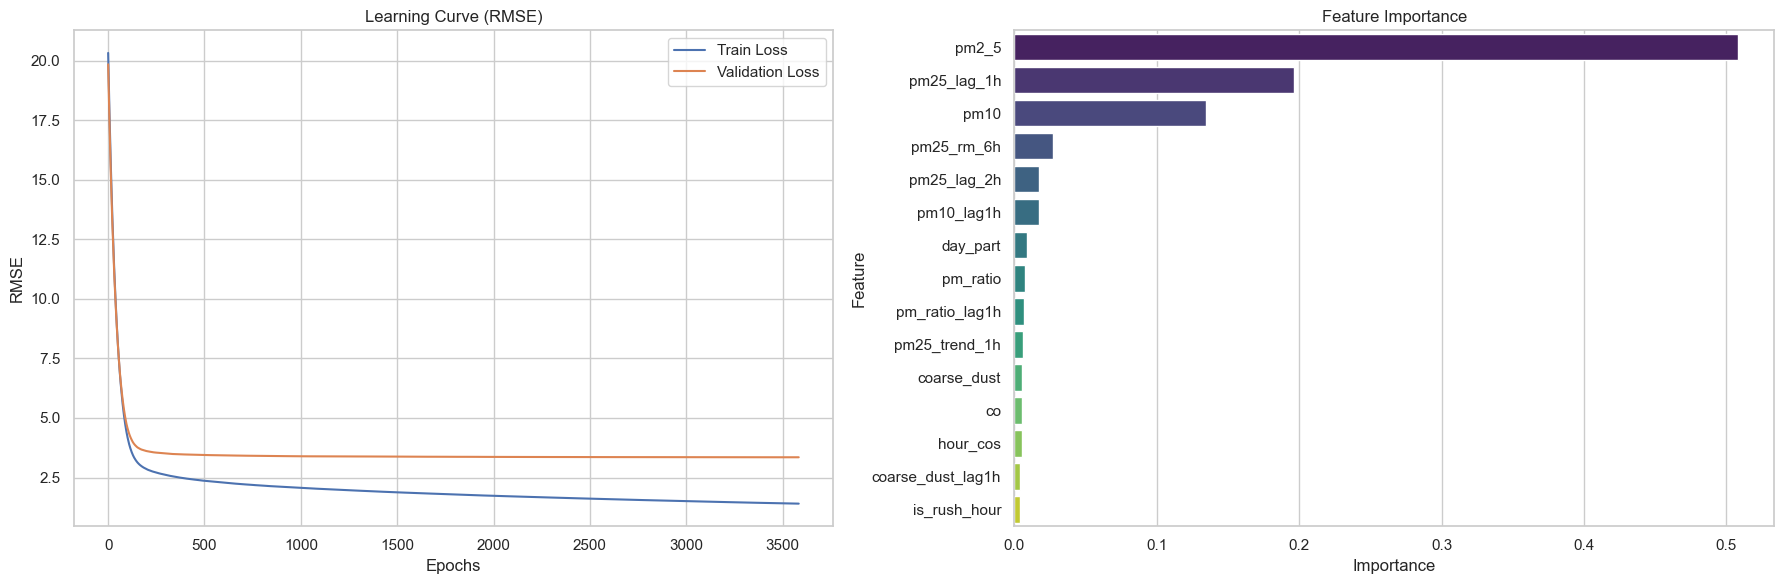

In [ ]:
plot_training_metrics(xgb_model, X_test_xgb)

#### 6.1. Final Model Performance on Test Set
After training, the model was evaluated on the completely unseen test set, yielding the following metrics:
|Metric|Value|Observation|
|:----:|:---:|:----------|
|**RMSE**|2.7106|Significant reduction compared to the Linear model|
|**MAE**|1.4037|Average error of approximately $1.4 \mu g/m^3$|
|**$R^2$ Score**|0.9770|Explains $97.7\%$ of the data variance|

**Comparison with Linear Regression:**
The XGBoost model demonstrates a substantial improvement over the baseline. Specifically, the model reduced the RMSE by 19.45% and the MAE by 21.37% compared to the Linear Regression results (RMSE: 3.3619, MAE: 1.7799).

While the linear model often flattens the peaks of pollution events by only learning average relationships, XGBoost closely tracks sudden fluctuations in PM2.5. An $R^2$ score of $0.977$ confirms that this is an exceptionally robust model for this task, capable of explaining nearly all variance in the air quality data.

#### 6.2. Insights from Feature Importance
Analyzing the Feature Importance chart reveals a fascinating point regarding the pm10 variable:
- **In the Linear Model**: We previously considered removing pm10 or pm2_5_lag due to multicollinearity. Keeping both in a linear model typically introduces noise and obscures the significance of regression coefficients.
- **In the Tree-based Model (XGBoost)**: pm10 has emerged as one of the top 3 most significant features contributing to the forecast.

**Why does this difference exist?**
Tree-based models are not adversely affected by multicollinearity in the same way as linear regression. Instead, XGBoost treats pm10 as a physical reference frame. Since PM2.5 is a subset of PM10, the interaction between them helps the model identify the proportion of fine dust within the total particulate matter. This leads to much more accurate predictions than looking at the history of PM2.5 alone.

### 7. Conclusion
The XGBoost model, supported by Optuna tuning, has successfully completed the PM2.5 forecasting task. The improvement of RMSE to $2.7$ and an $R^2$ of $0.977$ shows that the model not only learns general rules but also handles the specific fluctuations of different cities effectively. Specifically, leveraging the tight physical relationship between PM10 and PM2.5 proves that tree-based models are a superior choice for air quality data compared to traditional linear approaches.